<a href="https://colab.research.google.com/github/Manuelaio/course_MG/blob/main/SVs_WGS_WES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



>**Structural Variants analysis**

Manta caller 



In [ ]:
Manta= read.table("/content/Manta_ex_DGV.bed", stringsAsFactors = F, header=T)
head(Manta)

,chrom,start,end,type,len,genotype,chrom_TS,start_TS,end_TS,type_TS,source,len_TS,overlap
,<chr>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>
1,chr1,839442,839499,DEL,57,0/1,chr1,837019,857280,INS,DGV,20261,57
2,chr1,934064,934904,DEL,840,1/1,chr1,933981,934728,DEL,LONG_READ,747,664
3,chr1,934064,934904,DEL,840,1/1,chr1,882968,5666143,DEL,LONG_READ,4783175,840
4,chr1,1666974,1667141,DEL,167,1/1,chr1,1666983,1667152,DEL,"LONG_READ,SVCLASSIFY",169,158
5,chr1,1666974,1667141,DEL,167,1/1,chr1,1653303,1716238,DEL,LONG_READ,62935,167
6,chr1,1666974,1667141,DEL,167,1/1,chr1,882968,5666143,DEL,LONG_READ,4783175,167


type,n
<chr>,<int>
DEL,4426
DUP,703


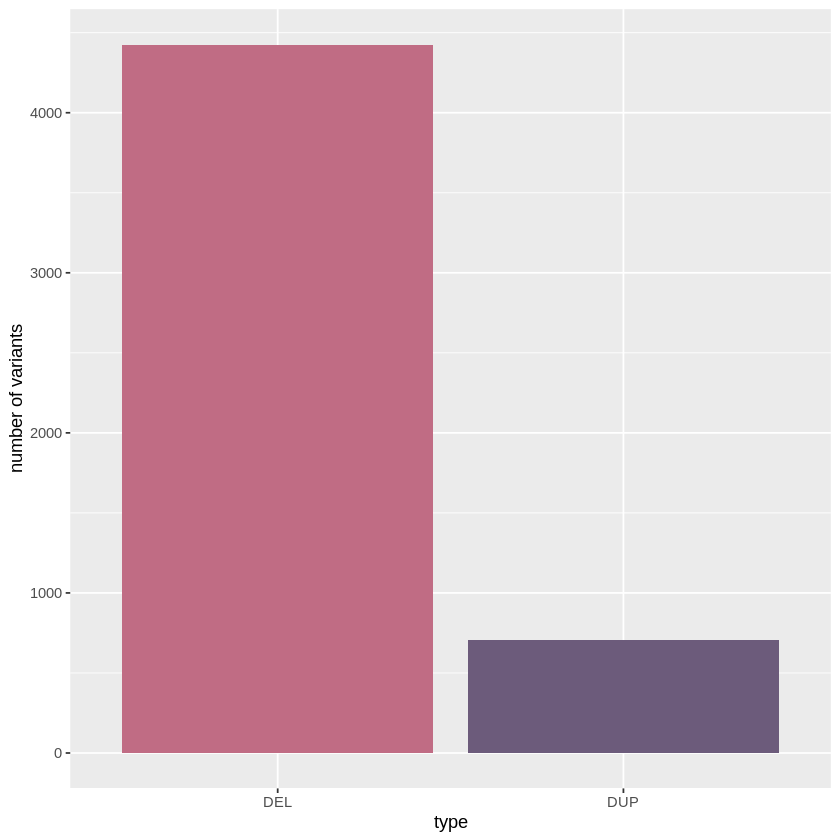

In [ ]:
library(dplyr)
library(ggplot2)

tab1=Manta %>%
  group_by(type) %>% 
  summarise(n = n()); tab1
#mycol=c("#C06C84", "#6C5B7B")
ggplot(tab1, aes(x=type, y= n)) + geom_col(fill= c("#C06C84", "#6C5B7B")) + ylab("number of variants") 



In [ ]:
Manta$evaluation= ifelse(Manta$overlap!=0, "TRUE_DISCOVERY","FALSE_DISCOVERY")
Manta$overlapLen= with(Manta, ifelse(len >= 10000 , ">10kb" , ifelse(len < 1000, "<1kb", ">1kb")))
table(Manta$evaluation, Manta$type)


                 
                   DEL  DUP
  FALSE_DISCOVERY  798  188
  TRUE_DISCOVERY  3628  515

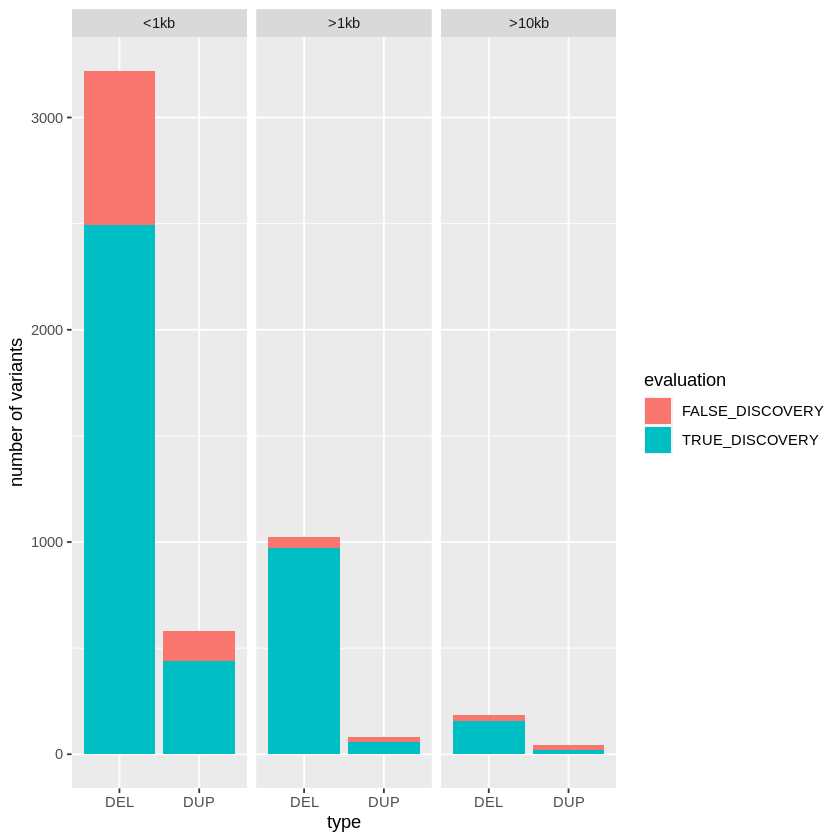

In [ ]:
tab2= Manta %>%
  group_by(type, evaluation, overlapLen, genotype) %>% 
  summarise(n = n(), .groups ="drop")

tab2$overlapLen= factor(tab2$overlapLen, levels= c("<1kb",">1kb",">10kb"))

  ggplot(tab2, aes(x=type, y= n,fill= evaluation)) + geom_col() +  facet_grid(.~overlapLen) + ylab("number of variants")

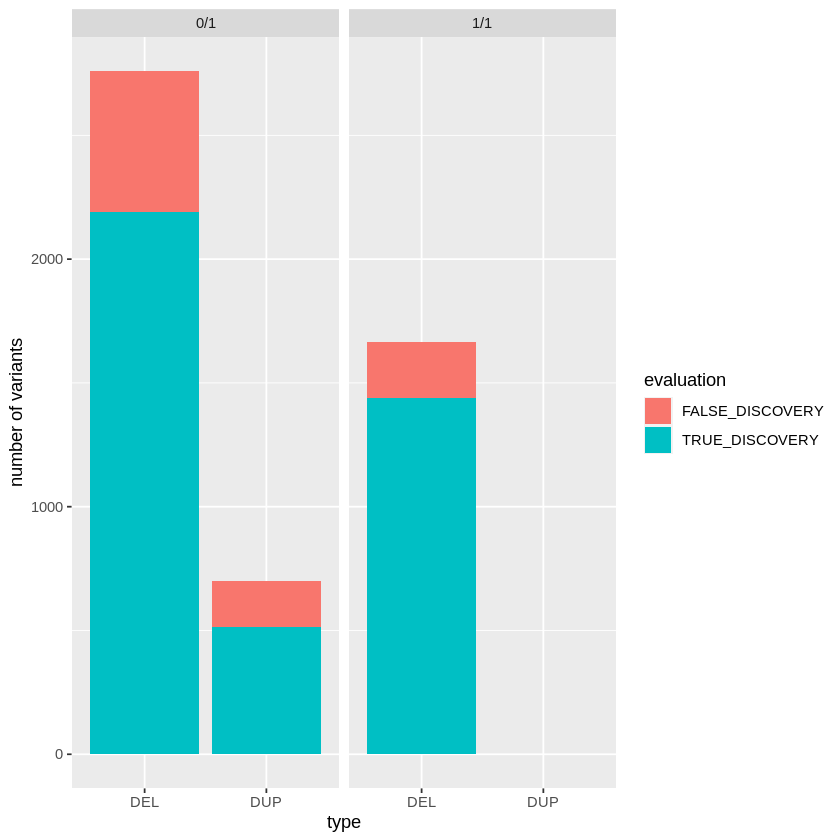

In [ ]:
ggplot(tab2, aes(x=type, y= n,fill= evaluation)) + geom_col() +  facet_grid(.~genotype) + ylab("number of variants")

In [ ]:
trueset=read.table("/content/NA12878_dgv_long_read_TRUESET.bed", stringsAsFactors = F)


In [64]:
PR_del <- function(data, data2){
  file.DEL= subset(data, type=="DEL")
  intersect.del= file.DEL[file.DEL$overlap!=0,]
 True.p= intersect.del[which(intersect.del$type==intersect.del$type_TS),]
 discordanti= intersect.del[which(intersect.del$type!=intersect.del$type_TS),]
 discordanti.na.omit= na.omit(discordanti)
 truset.del= subset(data2, V4=="DEL")
 TP= nrow(intersect.del[which(intersect.del$type==intersect.del$type_TS),])
 FN= (nrow(truset.del)) - TP - (nrow(discordanti.na.omit))
 FP= sum((nrow(file.DEL[file.DEL$overlap==0,])), (nrow(discordanti.na.omit)))
 PRECISIONE= ((TP)/(TP+FP))*100

 RECALL=  ((TP)/(TP+ abs(FN)))*100
 
 df <- data.frame(PRECISIONE,RECALL, TP, FN, FP)
 colnames(df) <- c("Precision","Recall","TP", "FN", "FP")
 return(df)
}


PR_dup <- function(data, data2){
  file.DUP= subset(data, type=="DUP")
  intersect.dup= file.DUP[file.DUP$overlap!=0,]
  True.p=intersect.dup[intersect.dup$type_TS=="DUP" | intersect.dup$type_TS=="INS",]
  discordanti_dup= intersect.dup[intersect.dup$type_TS=='DEL',]
  truset.dup= subset(data2, V4=="DUP")
  TP= nrow(True.p)
  FN= (nrow(truset.dup)) - TP - (nrow(discordanti_dup))
  FP= sum((nrow(file.DUP[file.DUP$overlap==0,])), (nrow(discordanti_dup)))
  PRECISIONE= ((TP)/(TP+FP))*100
  RECALL=  ((TP)/(TP+ abs(FN)))*100
  df <- data.frame(PRECISIONE,RECALL, TP, FN, FP)
 colnames(df) <- c("Precision","Recall","TP", "FN", "FP")
 return(df)
  
}


PR_del(Manta, trueset)
PR_dup(Manta, trueset)

Precision,Recall,TP,FN,FP
<dbl>,<dbl>,<int>,<int>,<int>
76.50249,38.47727,3386,5414,1040


Precision,Recall,TP,FN,FP
<dbl>,<dbl>,<int>,<int>,<int>
65.7554,18.56214,457,2005,238


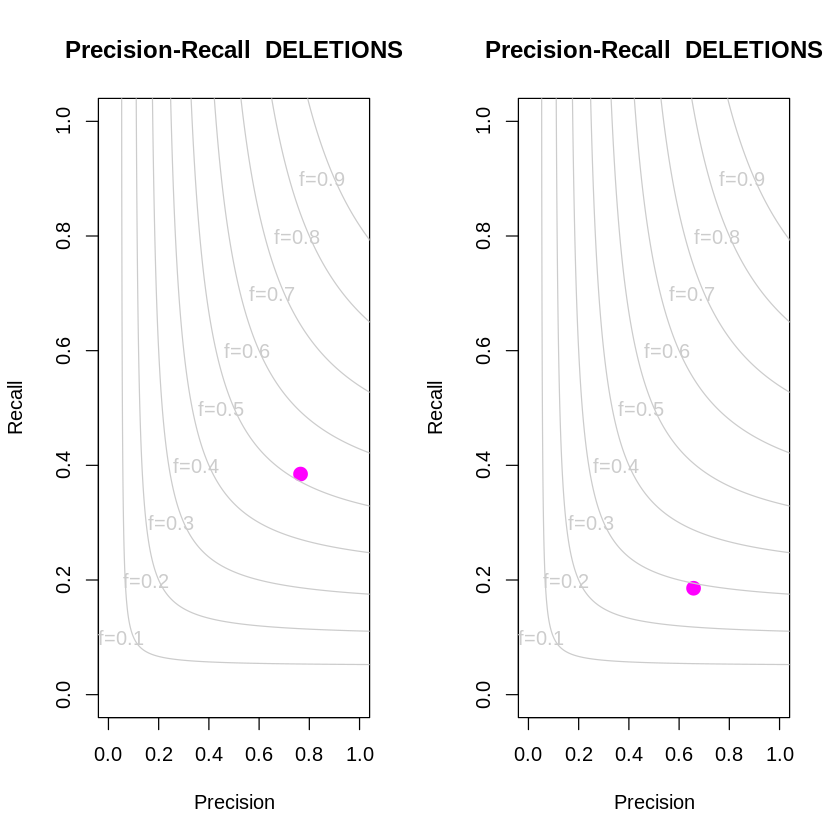

In [65]:
DEL= PR_del(Manta, trueset)
DUP=PR_dup(Manta, trueset)
DEL$Precision= DEL$Precision/100; DEL$Recall= DEL$Recall/100
DUP$Precision= DUP$Precision/100; DUP$Recall= DUP$Recall/100

xlab="Precision"
ylab<-"Recall"
par(mfrow=c(1,2))
plot(DEL$Precision,DEL$Recall,xlim=c(0,1),ylim=c(0,1),col="magenta",pch=19,main="Precision-Recall  DELETIONS",cex=1.5,xlab=xlab,ylab=ylab)
P<-seq(0.05,2,by=0.001)
FVec<-seq(0.1,0.9,by=0.1)
for (i in 1:9)
{
  
  F<-FVec[i]
  R<-F*P/(2*P-F)
  if (i!=9 & i!=7)
  {
    lines(P,R,col="gray80")
  }
  if (i==9)
  {
    lines(P[700:1000],R[700:1000],col="gray80")
  }
  if (i==7)
  {
    lines(P[400:1000],R[400:1000],col="gray80")
  }
}
text(0.05,0.1,"f=0.1",col="gray80")
text(0.15,0.2,"f=0.2",col="gray80")
text(0.25,0.3,"f=0.3",col="gray80")
text(0.35,0.4,"f=0.4",col="gray80")
text(0.45,0.5,"f=0.5",col="gray80")
text(0.55,0.6,"f=0.6",col="gray80")
text(0.65,0.7,"f=0.7",col="gray80")
text(0.75,0.8,"f=0.8",col="gray80")
text(0.85,0.9,"f=0.9",col="gray80")

plot(DUP$Precision,DUP$Recall,xlim=c(0,1),ylim=c(0,1),col="magenta",pch=19,main="Precision-Recall  DELETIONS",cex=1.5,xlab=xlab,ylab=ylab)
P<-seq(0.05,2,by=0.001)
FVec<-seq(0.1,0.9,by=0.1)
for (i in 1:9)
{
  
  F<-FVec[i]
  R<-F*P/(2*P-F)
  if (i!=9 & i!=7)
  {
    lines(P,R,col="gray80")
  }
  if (i==9)
  {
    lines(P[700:1000],R[700:1000],col="gray80")
  }
  if (i==7)
  {
    lines(P[400:1000],R[400:1000],col="gray80")
  }
}
text(0.05,0.1,"f=0.1",col="gray80")
text(0.15,0.2,"f=0.2",col="gray80")
text(0.25,0.3,"f=0.3",col="gray80")
text(0.35,0.4,"f=0.4",col="gray80")
text(0.45,0.5,"f=0.5",col="gray80")
text(0.55,0.6,"f=0.6",col="gray80")
text(0.65,0.7,"f=0.7",col="gray80")
text(0.75,0.8,"f=0.8",col="gray80")
text(0.85,0.9,"f=0.9",col="gray80")